# TODO

- Focal lossのパラメータチューニング

# Setting

In [1]:
import sys

import polars as pl
import seaborn as sns

root_dir = "../../"
if root_dir not in sys.path:
    sys.path.append(root_dir)
from modules import config as cfg
from modules import utils, preprosess, training, predict, metrics

exp = "exp07"
utils.set_seed(cfg.Params.seed)

# Read data

In [2]:
train, test, submit = utils.get_data(debug_mode=False)

# Preprocessing

## Split fold

In [3]:
train = preprosess.assign_stratified_k_fold(train, "MIS_Status")

## Convert

In [4]:
# Cityを座標に変換
train = preprosess.convert_city_to_latlon(train)
test  = preprosess.convert_city_to_latlon(test)

# testのBankStateの"PR"はtrainにないため，一番多いCAに変換
test = test.with_columns(pl.col("BankState").str.replace("PR", "CA"))

# DisbursementDateとApprovalDateをYear(数値)に変換
cols  = ["DisbursementDate", "ApprovalDate"]
train = preprosess.convert_date_to_year(train, cols)
test  = preprosess.convert_date_to_year(test, cols)

# 金額データの数値化
cols  = ["DisbursementGross",  "GrAppv", "SBA_Appv"]
train = preprosess.convert_money_data(train, cols)
test  = preprosess.convert_money_data(test, cols)

# 一致しているか
eqs = [
    ["State", "BankState"],
]
train = preprosess.add_eq(train, eqs)
test  = preprosess.add_eq(test, eqs)

# 差の計算
diffs = [
    ["DisbursementGross", "GrAppv"],   # 支払われた額 vs 銀行承認額
    ["DisbursementGross", "SBA_Appv"], # 支払われた額 vs SBA承認額
    ["GrAppv", "SBA_Appv"],            # 銀行承認額 vs SBA承認額
]
train = preprosess.add_diff(train, diffs)
test  = preprosess.add_diff(test, diffs)

# DisbursementDateとApprovalDateの差を計算
train = preprosess.add_diff_disbursement_with_approval(train)
test  = preprosess.add_diff_disbursement_with_approval(test)

# 割合の計算
divs = [
    # ["DisbursementGross", "Term"],
    ["GrAppv", "Term"],
    ["SBA_Appv", "Term"],
    ["NoEmp", "Term"],
    # ["DisbursementGross", "NoEmp"],
    # ["GrAppv", "NoEmp"],
    # ["SBA_Appv", "NoEmp"],
    ["DisbursementGross_GrAppv_diff", "Term"],
    ["DisbursementGross_SBA_Appv_diff", "Term"],
    ["GrAppv_SBA_Appv_diff", "Term"],
    # ["DisbursementGross_GrAppv_diff", "NoEmp"],
    # ["DisbursementGross_SBA_Appv_diff", "NoEmp"],
    # ["GrAppv_SBA_Appv_diff", "NoEmp"]
]
train = preprosess.add_div(train, divs)
test  = preprosess.add_div(test, divs)

# Sectorを職業別にする
train = preprosess.unify_same_sector(train)
test  = preprosess.unify_same_sector(test)

## Target encoding

In [5]:
cols = [
    # "Sector",
    "UrbanRural",
    "RevLineCr",
    "LowDoc",
    "FranchiseCode",
]
target_col = "MIS_Status"
train, test = preprosess.target_encoding(train, test, cols)

## Label encoding
CVによるtarget encodingでは同じカテゴリカル変数に異なる値が割り当てられるのでlabel encodingを併用する

In [6]:
cols = ["RevLineCr", "LowDoc"]
train, test = preprosess.label_encoding(train, test, cols)

# Drop columns

In [7]:
# 不要なカラムの削除
del_cols = [
    # 地名系
    "City",
    "State",
    "BankState",
    # d-b-y系
    "DisbursementDate",
    "ApprovalDate",
    "ApprovalFY",
    # ラベルエンコーディング済み
    "RevLineCr",
    "LowDoc",
]
train = train.drop(del_cols)
test  = test.drop(del_cols)

# Training + Tuning

In [8]:
lgb_params = {
    'objective': 'binary',
    'metric': 'custom',
    'boosting_type': 'gbdt',
    'seed': cfg.Params.seed,
    'learning_rate': cfg.Params.learning_rate,
}

alpha_li = [0.1, 0.2, 0.3, 0.4, 0.5]
gamma_li = [1.0, 2.0, 3.0, 4.0, 5.0]

threshold = 0.0
results_df = pl.DataFrame([
        pl.Series("alpha", [], dtype=pl.Float64),
        pl.Series("gamma", [], dtype=pl.Float64),
        pl.Series("score", [], dtype=pl.Float64)
])
for alpha in alpha_li:
    for gamma in gamma_li:
        oof, models = training.fit_lgbm_fl(train, lgb_params=lgb_params, alpha=alpha, gamma=gamma)
        oof_truth = train[cfg.Cols.target].to_numpy()
        oof_hat = predict.predict_class(oof, threshold=threshold)
        cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
        results_df = results_df.vstack(pl.DataFrame({"alpha": [alpha], "gamma": [gamma], "score": [cv_score]}))

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4971
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0330059	valid_1's focal_loss: 0.0569102
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0330059	valid_1's focal_loss: 0.0569102
Time:  4.551[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012216 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0332233	valid_1's focal_loss: 0.0565188
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0332233	valid_1's focal_loss: 0.0565188
Time:  4.531[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008727 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008078 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0170461	valid_1's focal_loss: 0.0284462
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0170461	valid_1's focal_loss: 0.0284462
Time:  3.422[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008902 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00884388	valid_1's focal_loss: 0.0143985
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00884388	valid_1's focal_loss: 0.0143985
Time:  4.562[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010829 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007108 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00445065	valid_1's focal_loss: 0.00736838
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00445065	valid_1's focal_loss: 0.00736838
Time:  4.267[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006783 seconds.
You can set `force_col_wise=true` to remove the overhead.


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010664 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00223934	valid_1's focal_loss: 0.0036388
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00223934	valid_1's focal_loss: 0.0036388
Time:  4.135[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005467 seconds.
You can set `force_row_wise=true` to remove the overhead.
An

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0447008	valid_1's focal_loss: 0.0699843
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0447008	valid_1's focal_loss: 0.0699843
Time:  3.494[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010636 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007031 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.022852	valid_1's focal_loss: 0.0360648
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.022852	valid_1's focal_loss: 0.0360648
Time:  3.426[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.072720 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Light

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.009225 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0116161	valid_1's focal_loss: 0.0184261
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0116161	valid_1's focal_loss: 0.0184261
Time:  4.770[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009291 seconds

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012803 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00593103	valid_1's focal_loss: 0.00938893
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00593103	valid_1's focal_loss: 0.00938893
Time:  4.232[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007220 seconds.
You can set `force_col_wise=true` to remove the overhead.


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011742 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00299934	valid_1's focal_loss: 0.00469394
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00299934	valid_1's focal_loss: 0.00469394
Time:  4.235[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010205 seconds.
You can set `force_col_wise=true` to remove the overhead.


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008849 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0496492	valid_1's focal_loss: 0.0751799
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0496492	valid_1's focal_loss: 0.0751799
Time:  3.307[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008089 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008201 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0254786	valid_1's focal_loss: 0.038937
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0254786	valid_1's focal_loss: 0.038937
Time:  3.382[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005698 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012101 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0131133	valid_1's focal_loss: 0.0202531
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0131133	valid_1's focal_loss: 0.0202531
Time:  4.205[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013597 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011866 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00667628	valid_1's focal_loss: 0.0103074
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00667628	valid_1's focal_loss: 0.0103074
Time:  4.754[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012343 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0034204	valid_1's focal_loss: 0.0051883
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0034204	valid_1's focal_loss: 0.0051883
Time:  4.264[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008870 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007222 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0508552	valid_1's focal_loss: 0.0761676
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0508552	valid_1's focal_loss: 0.0761676
Time:  3.370[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007678 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007910 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0265355	valid_1's focal_loss: 0.0392684
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0265355	valid_1's focal_loss: 0.0392684
Time:  3.249[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007399 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010580 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0136584	valid_1's focal_loss: 0.0206465
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0136584	valid_1's focal_loss: 0.0206465
Time:  4.266[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005397 seconds.
You can set `force_row_wise=true` to remove the overhead.
And 

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009698 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0069769	valid_1's focal_loss: 0.0105655
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0069769	valid_1's focal_loss: 0.0105655
Time:  4.296[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007168 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011177 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00356407	valid_1's focal_loss: 0.00545744
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00356407	valid_1's focal_loss: 0.00545744
Time:  4.392[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008792 seconds.
You can set `force_col_wise=true` to remove the overhead.


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007081 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0491239	valid_1's focal_loss: 0.0724125
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0491239	valid_1's focal_loss: 0.0724125
Time:  3.955[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013313 seconds

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008566 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0260874	valid_1's focal_loss: 0.0383631
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0260874	valid_1's focal_loss: 0.0383631
Time:  3.503[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009507 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.0135196	valid_1's focal_loss: 0.0198946
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.0135196	valid_1's focal_loss: 0.0198946
Time:  4.369[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[Lig

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008847 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00697034	valid_1's focal_loss: 0.0102716
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00697034	valid_1's focal_loss: 0.0102716
Time:  4.507[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008762 seconds.
You can set `force_col_wise=true` to remove the overhead.
[L

/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006665 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00355521	valid_1's focal_loss: 0.00537717
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00355521	valid_1's focal_loss: 0.00537717
Time:  3.633[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006996 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [9]:
results_df

alpha,gamma,score
f64,f64,f64
0.1,1.0,0.623095
0.1,2.0,0.620292
0.1,3.0,0.623376
0.1,4.0,0.623967
0.1,5.0,0.623208
0.2,1.0,0.667733
0.2,2.0,0.671487
0.2,3.0,0.670898
0.2,4.0,0.67159


alpha = 0.2
gamma = 2.0 ~ 5.0

In [10]:
alpha = 0.2
gamma = 3.5
oof, models = training.fit_lgbm_fl(train, lgb_params=lgb_params, alpha=alpha, gamma=gamma)

--------------------------------------------------------------------------------
START fold 1
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006791 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4971
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00830341	valid_1's focal_loss: 0.0130257
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00830341	valid_1's focal_loss: 0.0130257
Time:  3.842[s]
--------------------------------------------------------------------------------
START fold 2


/Users/taichi/anaconda3/envs/kaggle/lib/python3.9/site-packages/lightgbm/basic.py:859: UserWarning: Converting data to scipy sparse matrix.
  _log_warning('Converting data to scipy sparse matrix.')


[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 4979
[LightGBM] [Info] Number of data points in the train set: 33845, number of used features: 31
[LightGBM] [Warning] Using self-defined objective function
Training until validation scores don't improve for 100 rounds
[100]	training's focal_loss: 0.00826603	valid_1's focal_loss: 0.0132106
Did not meet early stopping. Best iteration is:
[100]	training's focal_loss: 0.00826603	valid_1's focal_loss: 0.0132106
Time:  4.785[s]
--------------------------------------------------------------------------------
START fold 3
[LightGBM] [Warning] Using self-defined objective function
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.008787 seconds.
You can set `force_row_wise=true` to remove the overhead.
An

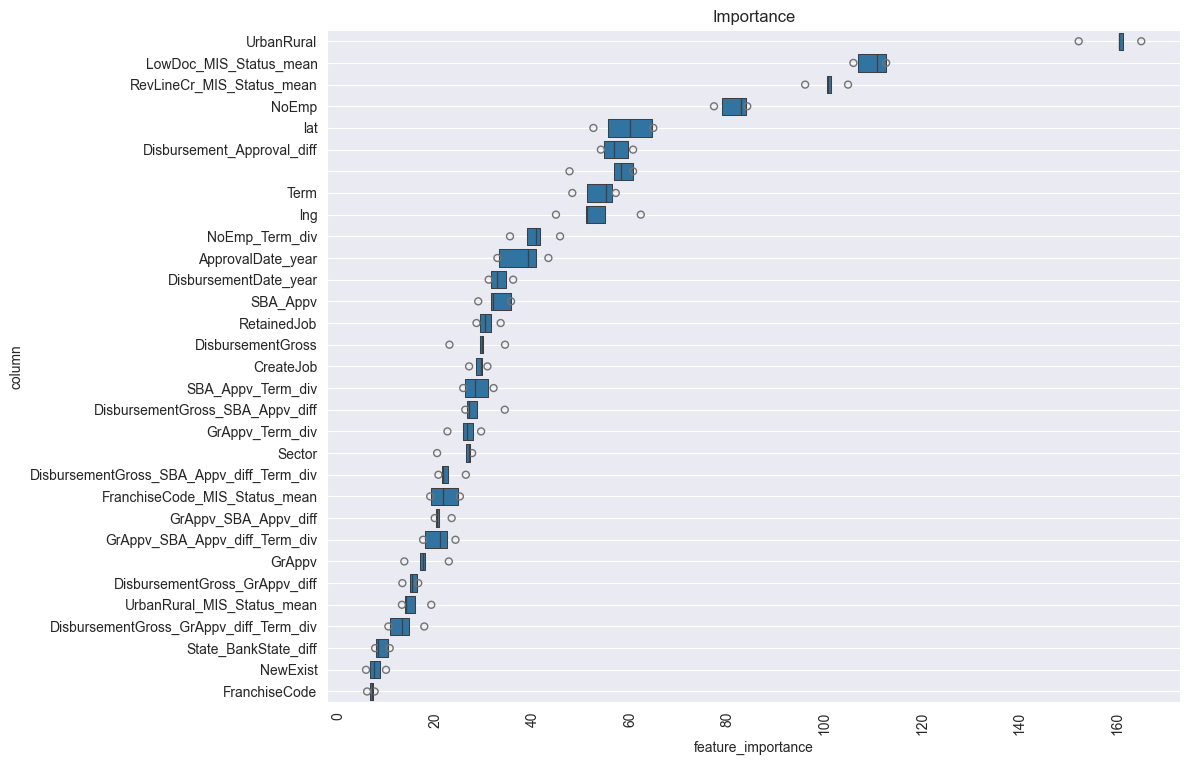

In [11]:
fig, ax = training.show_feature_importance(models, train)

# Predict

In [21]:
threshold = 0.0

In [22]:
pred_prob = predict.predict_probability(models, test)
pred_class = predict.predict_class(pred_prob, threshold=threshold)

## CV score

In [23]:
oof_truth = train[cfg.Cols.target].to_numpy()
oof_hat = predict.predict_class(oof, threshold=threshold)
cv_score = metrics.macro_f1_score(oof_truth, oof_hat)
print(cv_score)

0.6713209919019326


## Check result

### oofとtestの予測値分布を比較してバグを確認

<Axes: ylabel='Count'>

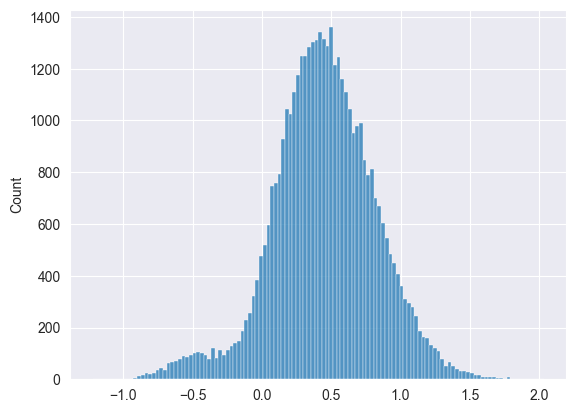

In [24]:
sns.histplot(oof)

<Axes: ylabel='Count'>

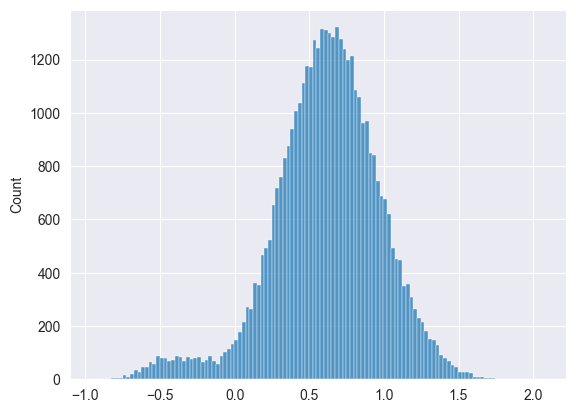

In [25]:
sns.histplot(pred_prob)

### 予測値の1の割合を確認

In [26]:
print(pred_class.sum() / len(pred_class))

0.9507185402287983


### oofにおける混同行列を確認

True Negative Rate (0の正解率): 0.38
True Positive Rate (1の正解率): 0.94


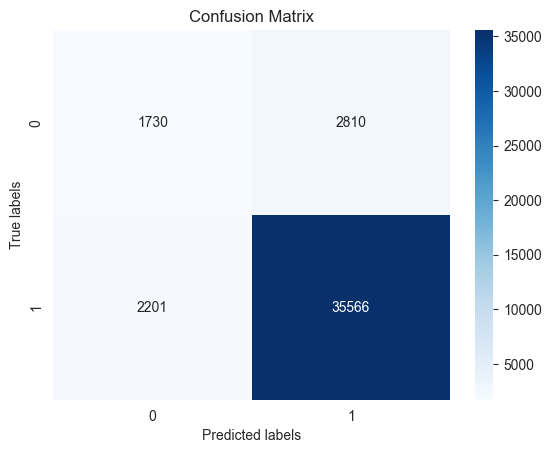

In [27]:
metrics.show_confusion_matrix(oof_truth, oof_hat)

## Submit

In [28]:
submit = submit.with_columns([pl.Series(cfg.Cols.sub_pred, pred_class)])
utils.make_submission(submit, exp, cv_score)